**Topic Modelling**

---

Techniques used


1.   Latent Dirichlet Allocation (LDA)
2.   Zero-Shot Encoding
3.   BERTopic



Import packages

In [ ]:
import csv
import pandas as pd

Testing Data

In [ ]:
testing_data_main = pd.read_csv('My_Bank_Data.csv')
testing_data_main.head()
data_table = testing_data_main.drop(testing_data_main.columns[[1, 3, 4]], axis=1)

LDA

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
associated_words = ['login', 'interface', 'stability', 'update', 'notifications', 'speed', 'service', 'functions', 'security']

In [ ]:
text_data = testing_data_main['review'].astype(str)

LDA_testing_data = testing_data_main
LDA_testing_data.dropna(subset=['review'], inplace=True)
tokenized_reviews = [word_tokenize(review.lower()) for review in LDA_testing_data['review']]
dictionary = Dictionary(tokenized_reviews)
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_reviews]
lda_model = LdaModel(corpus, num_topics=len(associated_words), passes=10, id2word=dictionary, eta='auto', eval_every=None, iterations=500, alpha='auto', random_state=42)
similarity_df = pd.DataFrame(index=LDA_testing_data.index, columns=associated_words)

for i, review in enumerate(tokenized_reviews):
    bow = dictionary.doc2bow(review)
    topics = lda_model.get_document_topics(bow)
    if topics:
        for j, word in enumerate(associated_words):
            # Find the maximum score if topics exist for the word, otherwise assign a default value
            topic_scores = [score for topic_id, score in topics if topic_id == j]
            max_score = max(topic_scores) if topic_scores else 0.0
            similarity_df.at[i, word] = max_score
    else:
        for word in associated_words:
            similarity_df.at[i, word] = 0.0

similarity_df = similarity_df.apply(pd.to_numeric)

data_table['LDA_associated_word'] = similarity_df.idxmax(axis=1)

In [ ]:
data_table.head()

,SN,review,label,label2,LDA_associated_word
0,1,"Their app is riddled with bugs, and transactio...",functions,service,security
1,2,The app freezes every time I try to make a tra...,speed,NaN,stability
2,3,Not only does it lack basic features like fing...,login,interface,stability
3,4,"the app is easy to use, and I appreciate the q...",speed,functions,security
4,5,"Constantly experiencing login errors, and when...",stability,login,stability


Zero-Shot

In [ ]:
from transformers import pipeline
import pandas as pd
import re

In [ ]:
classifier = pipeline("zero-shot-classification")
associated_words = ['login', 'interface', 'stability', 'update', 'notifications', 'speed', 'service', 'functions', 'security']

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ZS_testing_data = testing_data_main
predictions = []
accuracy_scores = []
for index, row in ZS_testing_data.iterrows():
    # Perform zero-shot classification on the title
    result = classifier(row['review'], associated_words)

    # Get the predicted associated word with the highest probability score
    predicted_associated_word = result['labels'][0]

    predictions.append(predicted_associated_word)

data_table['Zero-Shot_associated_word'] = pd.DataFrame(predictions)

In [ ]:
data_table.head()

,SN,review,label,label2,LDA_associated_word,Zero-Shot_associated_word
0,1,"Their app is riddled with bugs, and transactio...",functions,service,security,service
1,2,The app freezes every time I try to make a tra...,speed,NaN,stability,interface
2,3,Not only does it lack basic features like fing...,login,interface,stability,interface
3,4,"the app is easy to use, and I appreciate the q...",speed,functions,security,speed
4,5,"Constantly experiencing login errors, and when...",stability,login,stability,login


BERTopic

In [ ]:
!pip install bertopic

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from itertools import chain
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
associated_words = ['login', 'interface', 'stability', 'update', 'notifications', 'speed', 'service', 'functions', 'security']

In [ ]:
BERT_testing_data = testing_data_main

# Define the preprocess_text function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join the tokens back into a string
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

def find_closest_associated_word(review_vector, associated_words, model):
    max_similarity = -1
    closest_word = None
    for word in associated_words:
        # Transform the word to its vector representation using the BERTopic model
        word_vector = model.encode([word])[0]
        # Compute cosine similarity between review vector and word vector
        similarity = cosine_similarity([review_vector], [word_vector])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word
    return closest_word

# Preprocess your text data as needed
BERT_testing_data['cleaned_review'] = BERT_testing_data['review'].apply(preprocess_text)

# Initialize a Sentence Transformer model with a pre-trained BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate BERT embeddings for your text data
embeddings = model.encode(BERT_testing_data['cleaned_review'], show_progress_bar = True)

# Convert BERT embeddings to strings
embeddings_strings = [np.array(embedding).astype(str) for embedding in embeddings]

# Initialize a BERTopic model
topic_model = BERTopic(language="english")

# Flatten the list of lists containing strings
embeddings_strings_flat = list(chain.from_iterable(embeddings_strings))

topics, _ = topic_model.fit_transform(embeddings_strings_flat)

# Get the closest associated word for each review vector
closest_words = [find_closest_associated_word(vector, associated_words, model) for vector in embeddings]

# Add the associated words as a new column to the DataFrame
data_table['BERT_associated_word'] = closest_words

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data_table.head()

,SN,review,label,label2,LDA_associated_word,Zero-Shot_associated_word,BERT_associated_word
0,1,"Their app is riddled with bugs, and transactio...",functions,service,security,service,notifications
1,2,The app freezes every time I try to make a tra...,speed,NaN,stability,interface,notifications
2,3,Not only does it lack basic features like fing...,login,interface,stability,interface,login
3,4,"the app is easy to use, and I appreciate the q...",speed,functions,security,speed,notifications
4,5,"Constantly experiencing login errors, and when...",stability,login,stability,login,login


Comparison of results

Accuracy of LDA

In [ ]:
LDA_words = similarity_df.idxmax(axis=1)
LDA_accuracy_scores = []
for i in range(len(LDA_words)):
    if LDA_words[i] == testing_data_main['label'][i] or LDA_words[i] == testing_data_main['label2'][i]:
        LDA_accuracy_scores.append(1)  # Correct prediction
    else:
        LDA_accuracy_scores.append(0)  # Incorrect prediction

LDA_accuracy = sum(LDA_accuracy_scores) / len(LDA_accuracy_scores)

print("LDA Accuracy Score:", LDA_accuracy)

LDA Accuracy Score: 0.2


Accuracy of Zero-Shot

In [ ]:
ZS_accuracy_scores = []
for i in range(len(predictions)):
    if predictions[i] == testing_data_main['label'][i] or predictions[i] == testing_data_main['label2'][i]:
        ZS_accuracy_scores.append(1)  # Correct prediction
    else:
        ZS_accuracy_scores.append(0)  # Incorrect prediction

ZS_accuracy = sum(ZS_accuracy_scores) / len(ZS_accuracy_scores)

print("Zero-Shot Accuracy Score:", ZS_accuracy)

Zero-Shot Accuracy Score: 0.6666666666666666


Accuracy of BERTopic

In [ ]:
BERT_accuracy_scores = []
for i in range(len(closest_words)):
    if closest_words[i] == testing_data_main['label'][i] or closest_words[i] == testing_data_main['label2'][i]:
        BERT_accuracy_scores.append(1)  # Correct prediction
    else:
        BERT_accuracy_scores.append(0)  # Incorrect prediction

BERT_accuracy = sum(BERT_accuracy_scores) / len(BERT_accuracy_scores)

print("BERTopic Accuracy Score:", BERT_accuracy)

BERTopic Accuracy Score: 0.4


Graphical representation of accuracies

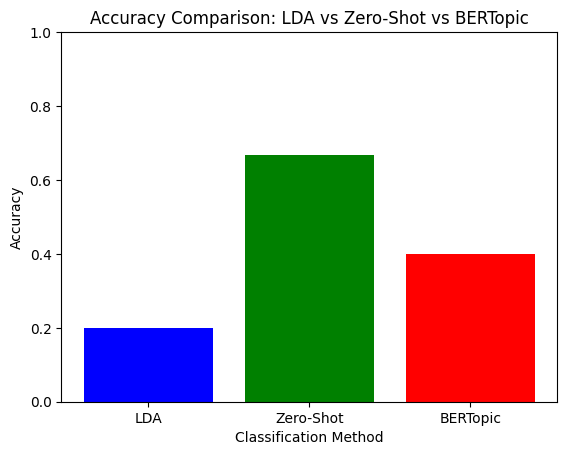

In [ ]:
import matplotlib.pyplot as plt

# Define labels for the bars
labels = ['LDA', 'Zero-Shot', 'BERTopic']

# Define the accuracy values for each method
accuracy_values = [LDA_accuracy, ZS_accuracy, BERT_accuracy]

# Plot the bar chart
plt.bar(labels, accuracy_values, color=['blue', 'green', 'red'])

# Add title and labels
plt.title('Accuracy Comparison: LDA vs Zero-Shot vs BERTopic')
plt.xlabel('Classification Method')
plt.ylabel('Accuracy')

# Set y-axis limits
plt.ylim(0, 1)

# Show the plot
plt.show()